# Create a single InputNorm layer and train it to reproduce the non-standardized PowerTransformer output with similar lambda values on dummy data

In [1]:
import numpy as np
from sklearn.preprocessing import PowerTransformer
from inputnorm import InputNorm

np.random.seed(12345)
N = 512
affine = False
missing = 0.05  # randomly replace data points with NaNs

# create dummy data
X = [
    np.random.normal(0.0, 0.1, N),
    np.random.normal(-3.0, 0.1, N),
    np.random.lognormal(1.0, 2.0, N),
    np.random.gumbel(0.0, 0.1, N),
    np.random.gamma(2.0, 2.0, N),
    np.random.power(3., N),
    np.random.uniform(0.0, 1.0, N),
    [np.nan] * N
]
X = np.array(X).T

# add more missing values at random
X = np.where(np.random.uniform(0.0, 1.0, X.shape) < missing, np.nan, X)

# fit the PowerTransformer on data
pt = PowerTransformer(method="yeo-johnson", standardize=affine)
pt.fit(X[:, :-1])  # fitting an all NaNs column would raise an error

# y is X transformed
y = pt.transform(X[:, :-1])
y = np.hstack((y, np.expand_dims(X[:, -1], -1)))  # reintroduce all NaN column

y.shape

(512, 8)

In [2]:
import torch
import matplotlib.pyplot as plt

epochs = 1000
batch_size = X.shape[0] // 8
device = "cuda:0" if torch.cuda.is_available() else "cpu"
num_batches = int(np.ceil(X.shape[0] / batch_size))


model = InputNorm(X.shape[-1], affine=affine, device=device)  # single "layer"
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.train()

print("device:", device)

device: cpu


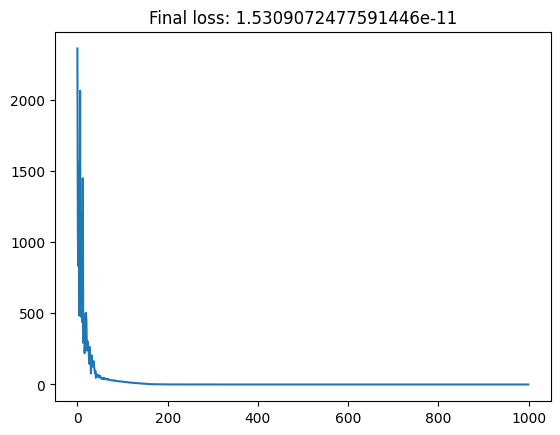

In [3]:
g = torch.Generator().manual_seed(12345)
losses = []
for i in range(epochs):
    blosses = []
    for b in range(num_batches):
        ix = torch.randint(0, X.shape[0], (batch_size, ), generator=g)
        X_batch, y_batch = X[ix], y[ix]
        X_batch, y_batch = torch.Tensor(X_batch).to(device), torch.Tensor(y_batch).to(device)
        y_pred = model(X_batch)

        # mask NaNs for calculating loss
        mask = torch.isfinite(y_batch)
        y_pred = torch.masked_select(y_pred, mask)
        y_true = torch.masked_select(y_batch, mask)
        loss = mse(y_pred, y_true)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        blosses.append(loss.item())
        assert np.isfinite(blosses[-1]), f"NaN encountered at epoch {i} / batch {b}!"
    
    losses.append(np.mean(blosses))

plt.plot(np.arange(len(losses)), losses)
plt.title(f"Final loss: {losses[-1]}")
plt.show();


In [7]:
print("Original lambdas:", pt.lambdas_.tolist() + [None])  # last column has no lambda with scikit-learn
print("Model lambdas   :", model.lambdas.detach().cpu().numpy().tolist())  # 1.0 is the identity

Original lambdas: [0.44784702475066307, -0.8773497592463756, -0.39943529991153354, -2.278847416880611, 0.004466045332337486, 4.907717212654821, 0.43314467447389865, None]
Model lambdas   : [0.4478476345539093, -0.8773496747016907, -0.3994348347187042, -2.2788374423980713, 0.004466029349714518, 4.907713890075684, 0.43314456939697266, 1.0]
